# Initializing

In [1]:
# Core
# Utils
from collections import Counter
from typing import Iterable, Literal, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.base import BaseSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE, KMeansSMOTE, RandomOverSampler

# Imbalanced learning
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# Base + Models
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)

# Preprocessing & Pipeline
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.utils.validation import check_is_fitted

# FraudDetector Class
A new method ```experiment_fit``` was made for demonstration and experimentation within this notebook. It allows us to easily switch between different class imbalance handling strategies (e.g., SMOTE, RandomUnderSampler, TomekLinks) and apply optional sample weights when fitting the model.

In [2]:
class FraudDetector(BaseEstimator, ClassifierMixin):

    def __init__(self, random_state: int = 39, n_jobs: Optional[int] = None):
        self.random_state = random_state
        self.n_jobs = n_jobs
        self._model_ = RandomForestClassifier(
            n_estimators=500,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )

    def fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        sample_weight: Optional[Iterable[float]] = None,
    ):
        """
        Fit the model using a training X and y.

        Parameters:
        -----------
        X (np.ndarray | pd.DataFrame): The training data
        y (np.ndarray | pd.Sereis): The corresponding targets
        sample_weight (iterable): Sample class weights (default=None)
        """

        X_balanced, y_balanced = self._handle_imbalance(
            X, y
        )  # you can modify the parameters here if needed
        if sample_weight is None:
            self._model_.fit(X_balanced, y_balanced)
        else:
            self._model_.fit(X_balanced, y_balanced, 
                             sample_weight=sample_weight)
        return self

    def experiment_fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        sample_strategy: Optional[BaseSampler] = None,
        sample_weight: Optional[Iterable[float]] = None,
    ) -> dict[str, np.ndarray]:
        """
        Fit an imbalanced-learn pipeline on the training data.

        This method is designed for experimentation. It allows you to
        easily switch between different class imbalance handling
        strategies (e.g., SMOTE, RandomUnderSampler) and apply optional
        sample weights when fitting the model.

        Parameters
        ----------
        X : np.ndarray | pd.DataFrame
            Training data.
        y : np.ndarray | pd.Series
            Target labels.
        sample_strategy : BaseSampler, optional
            Resampling strategy (default=None).
        sample_weight : iterable, optional
            Sample weights for fitting (default=None).

        Returns
        -------
        dict
            Contains the key:value pair of str to the mean validation scores
        """
        # Build pipeline
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=36)

        # Build pipeline
        steps = []
        if sample_strategy is not None:
            steps.append(
                ("sampler", sample_strategy)
            )  # e.g., SMOTE(), RandomUnderSampler()
        steps.append(("clf", self._model_))

        pipeline = Pipeline(steps=steps)

        # Define the scorers
        fcr_scorer = make_scorer(recall_score, pos_label=1)

        # Detection: macro recall
        detection_scorer = make_scorer(recall_score, average="macro")

        scorers = {
            "precision": make_scorer(precision_score, 
                                     average="macro", 
                                     zero_division=0),
            "recall": make_scorer(recall_score, 
                                  average="macro", 
                                  zero_division=0),
            "f1": make_scorer(f1_score, average="macro", zero_division=0),
            "fcr": fcr_scorer,
            "detection": detection_scorer,
            "abs_net_value": FraudDetector.abs_net_value_scorer,
            "rel_net_value": FraudDetector.rel_net_value_scorer,
        }

        # GridSearchCV
        if sample_weight is not None:
            param_grid = {"clf__n_estimators": [500], 
                          "clf__class_weight": ["balanced"]}
        else:
            param_grid = {
                "clf__n_estimators": [500],
            }

        search = GridSearchCV(
            estimator=pipeline,
            scoring=scorers,
            param_grid=param_grid,
            refit="fcr",
            cv=skf,
            n_jobs=-1,
            verbose=1,
        )

        search.fit(X, y)

        return search.cv_results_

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """Predict the outcome from data X."""
        check_is_fitted(self, "_model_")
        return self._model_.predict(X)

    def fit_predict(
        self, X: Union[np.ndarray, pd.DataFrame], 
        y: Union[np.ndarray, pd.Series]
    ) -> np.ndarray:
        """
        Fit the model using a training X and y, and predict the outcome using
        X. Note that this would give the predicted labels during training.
        """
        return self.fit(X, y).predict(X)

    def _handle_imbalance(self, X, y):
        return X, y

    #### END MODIFY THIS METHOD

    # Helper functions
    @staticmethod
    def abs_net_value_scorer(estimator, X, y):
        """Compute the absolute net monetary value.
        
        Calculates the total value of fraud correctly detected and subtracts
        the value of legitimate transactions incorrectly flagged.
        """

        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y_pred = estimator.predict(X)
        amount = X.iloc[:, -1]  # last column as transaction value
        caught_value = amount[(y == 1) & (y_pred == 1)].sum()
        innocent_flagged = amount[(y == 0) & (y_pred == 1)].sum()
        return caught_value - innocent_flagged

    @staticmethod
    def rel_net_value_scorer(estimator, X, y):
        """Compute the relative net monetary value.

        Returns the net value gained (fraud caught minus false positives)
        normalized by the total fraud value in the dataset.
        """
        
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y_pred = estimator.predict(X)
        amount = X.iloc[:, -1]  # last column as transaction value
        caught_value = amount[(y == 1) & (y_pred == 1)].sum()
        total_fraud = amount[(y == 1)].sum()
        innocent_flagged = amount[(y == 0) & (y_pred == 1)].sum()
        return (
            (caught_value - innocent_flagged) / total_fraud
            if total_fraud != 0
            else 0
        )

# EDA

Our overall objectives are:
1. To understand why the older methods of thresholding and flagging unusual transaction amounts are no longer effective.
2. To improve the prediction of fraudulent transactions.

For the first objective, we will examine patterns that differentiate fraudulent transactions from non-fraudulent ones by doing an EDA.
For the second objective, we will evaluate different sampling strategies and class weighting while keeping the Random Forest classifier with 500 estimators as a controlled variable. This is because Mara has already established that baseline, and our goal is to build on top of her work.


In [3]:
df = pd.read_csv("historical.csv")

# Drop tid because it is just a unique id
df = df.drop(columns=["tid"])

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,0.635636,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,-1.470780,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,-0.947894,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,0.080683,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,-1.054033,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


In [4]:
df.shape

(185124, 30)

## Data Preprocessing

No missing data were found, but duplicate entries were identified and removed. A total of 4,670 duplicates were dropped, leaving 97.4% of the data for analysis.

In [5]:
print(f"Number of missing data points is {df.isnull().sum().sum()}.")
print(f"Number of duplicated data points is {df.duplicated().sum()}.")

# Deduplicate the dataframe
df = df.drop_duplicates()

Number of missing data points is 0.
Number of duplicated data points is 4670.


## 1. To understand why the older methods of thresholding and flagging unusual transaction amounts are no longer effective

First, there is relatively little data available on fraudulent transactions, with at most 305 cases recorded in the ```historical.csv``` dataset while having 180,149 non-fraudulent cases. As shown in Figure 1, this results in a pronounced class imbalance between fraudulent and non-fraudulent transactions.

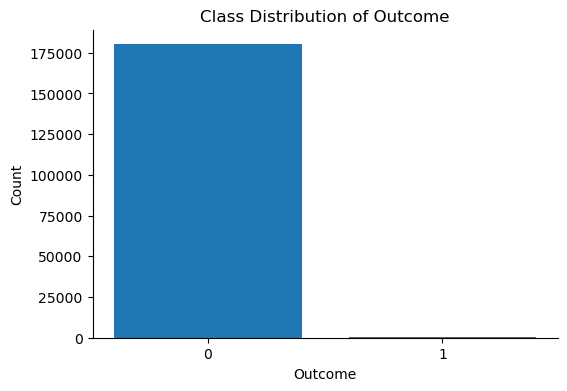

In [6]:
# Count values
class_counts = df["outcome"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution of Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

Second, the traditional methods of thresholding and flagging unusual transaction amounts are no longer effective because fraudsters have adapted to these rules. As shown in the box plot in Figure 2, the median transaction amount for fraud cases is actually lower than that of non-fraud cases. Furthermore, even the outliers among fraudulent transactions are not as extreme when compared to non-fraudulent ones. While non-fraud transactions can reach values on the order of $10^4$, the highest fraudulent transactions only reach around $10^3$.

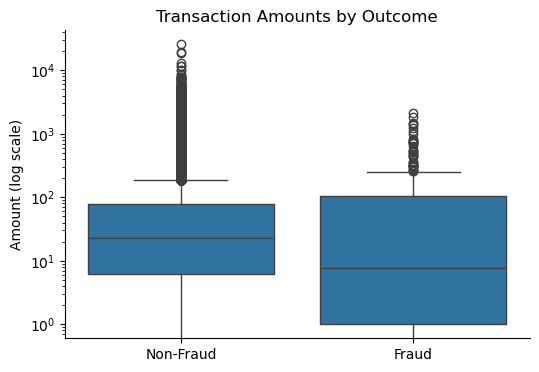

In [7]:
plt.figure(figsize=(6, 4))

sns.boxplot(x="outcome", y="Amount", data=df)
plt.yscale("log")  # handle skewness
plt.title("Transaction Amounts by Outcome")
plt.xlabel("")
plt.ylabel("Amount (log scale)")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

In contrast to using only transaction amounts, we can also look at the principal components. Figure 3 shows little to no correlation among non-fraudulent transactions while fraudulent transactions display stronger relationships in the heatmap. This suggests that fraud data contains patterns that machine learning can exploit to improve prediction.

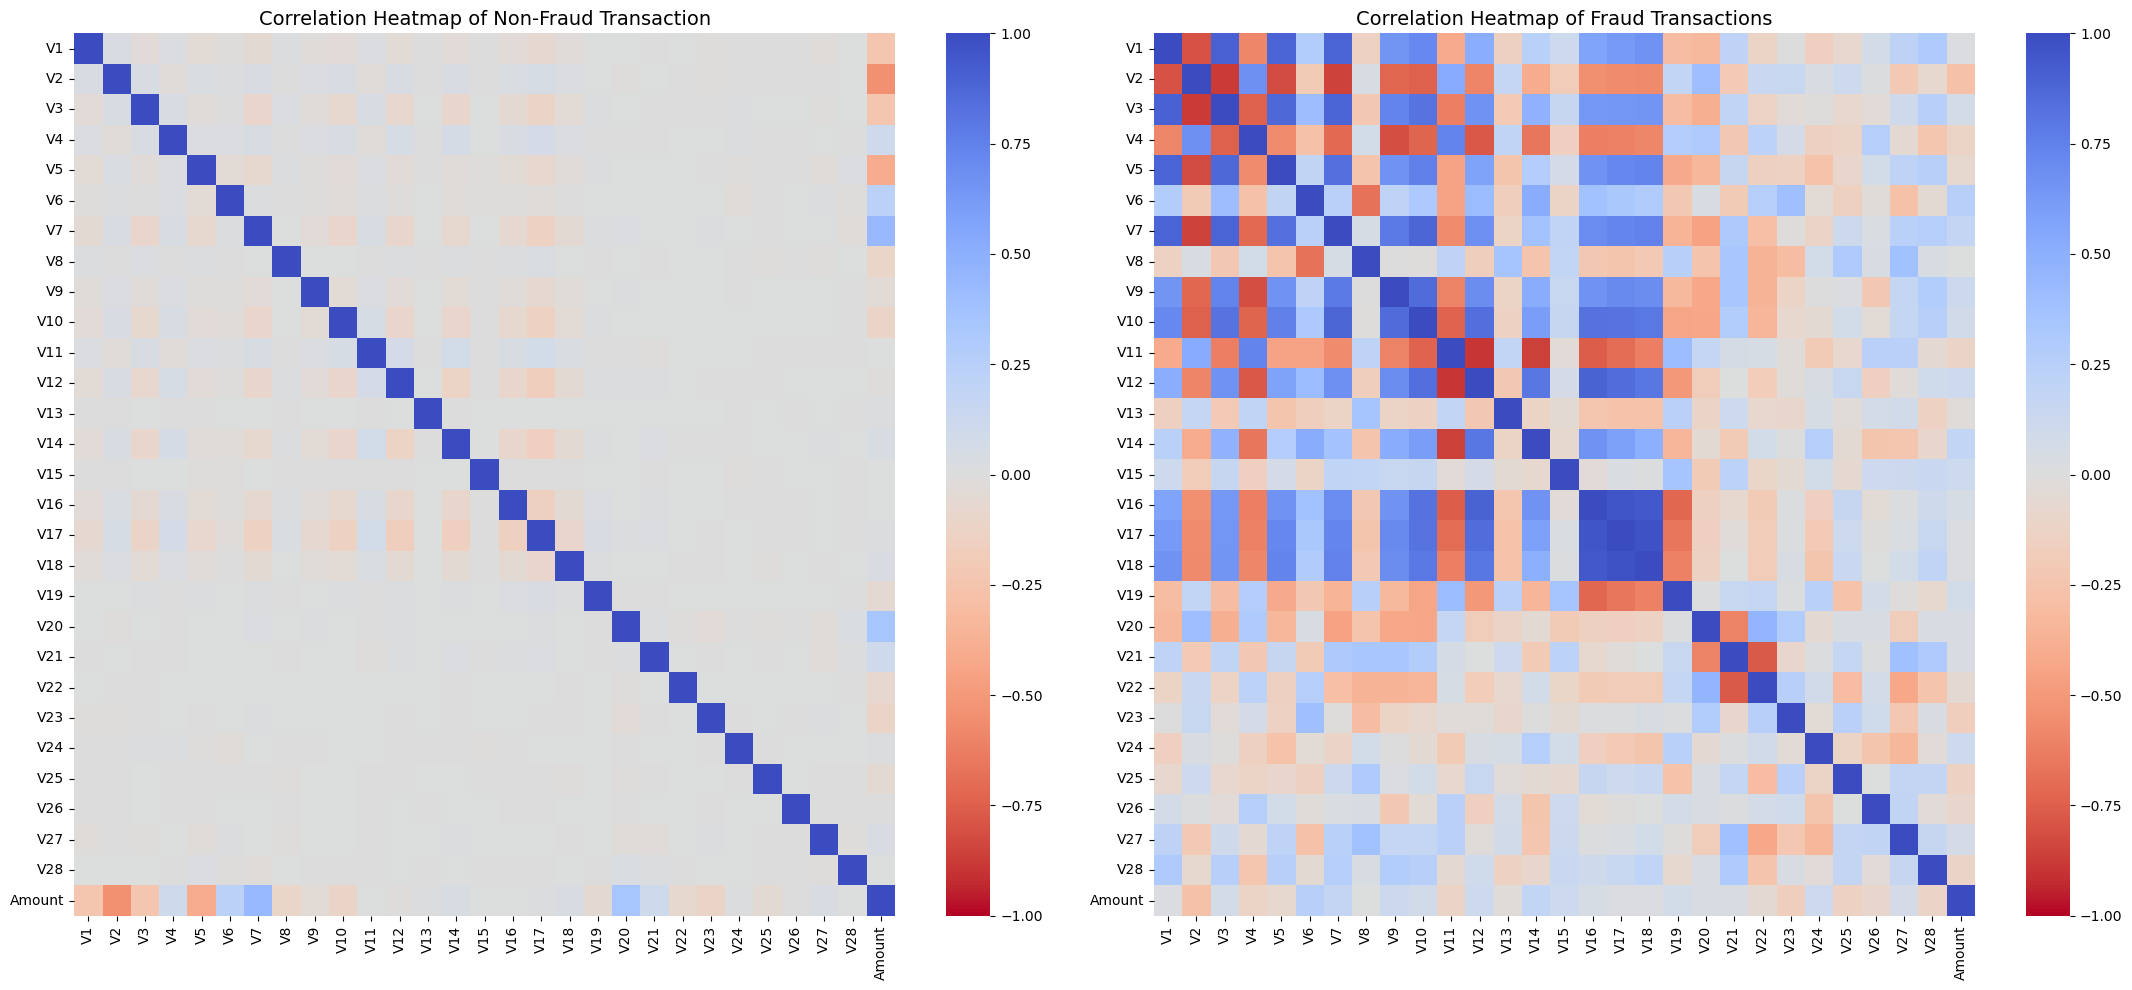

In [8]:
# Split datasets
is_fraud = df["outcome"] == 1
df_0 = df[~is_fraud]
df_1 = df[is_fraud]

# Compute correlation matrices
corr_0 = df_0.iloc[:, :-1].corr()
corr_1 = df_1.iloc[:, :-1].corr()

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(
    corr_0,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[0],
)
axes[0].set_title("Correlation Heatmap of Non-Fraud Transaction", 
                  fontsize=14)

sns.heatmap(
    corr_1,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[1],
)
axes[1].set_title("Correlation Heatmap of Fraud Transactions", fontsize=14)

plt.tight_layout()
plt.show()

To further visualize the patterns in fraud data, two scatterplots were made in Figure 4 to show the relationships of V1 to V3 (a) and V18 to V16 (b). These plots further emphasizes how fraud transactions (red) cluster differently from non-fraud ones (blue), suggesting that certain components capture meaningful distinctions between the two classes.

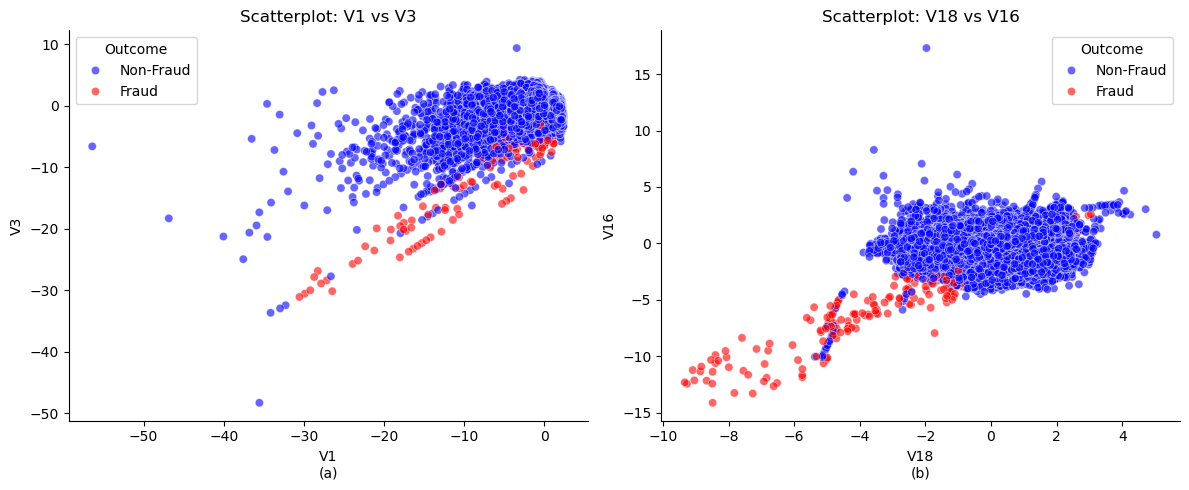

In [9]:
plt.figure(figsize=(12, 5))

# V1 vs V3
plt.subplot(1, 2, 1)
ax1 = sns.scatterplot(
    data=df, x="V1", y="V3", hue="outcome", alpha=0.6, 
    palette={0: "blue", 1: "red"}
)
legend1 = ax1.legend_
legend1.set_title("Outcome")
for t, new_label in zip(legend1.texts, ["Non-Fraud", "Fraud"]):
    t.set_text(new_label)
plt.title("Scatterplot: V1 vs V3")
ax1.set_xlabel("V1\n(a)")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


# V18 vs V16
plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(
    data=df, x="V18", y="V16", hue="outcome", alpha=0.6, 
    palette={0: "blue", 1: "red"}
)
legend2 = ax2.legend_
legend2.set_title("Outcome")
for t, new_label in zip(legend2.texts, ["Non-Fraud", "Fraud"]):
    t.set_text(new_label)
plt.title("Scatterplot: V18 vs V16")
ax2.set_xlabel("V18\n(b)")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

## 2. To improve the prediction of fraudulent transactions.

Let us now define the metrics that we shall use to optimize the model. We have:
1. Detection Rate
    * This asks, "Out of all transactions, how well does the model is at correctly identifying both fraud and non-fraud overall, where both are equally important?"

2. Fraud Capture Rate
    * This asks, "Out of all the fraud cases, how many did the model actually catch?"

3. Net Value Gained  - 
    * This asks, "How much money does the model helps save (by catching fraud)?"

Because we can only use one metric to optimize the model, we choose the Fraud Capture Rate to optimize since our second objective is to improve the prediction of fraudulent transactions. This metric aligns closely with CreditByte’s business-critical goal of reducing credit card fraud. For additional business context, we also report Net Value Gained to reflect the monetary impact. The technical definitions of all metrics used are provided below.

1. **Detection Rate which is the same as Macro Recall**  
Detection Rate:  

$$
\text{Detection Rate} = \frac{1}{2} \bigg(\frac{TP_{\text{fraud}}}{TP_{\text{fraud}} + FN_{\text{fraud}}} + \frac{TP_{\text{nonfraud}}}{TP_{\text{nonfraud}} + FN_{\text{nonfraud}}} \bigg)
$$

where  
- $n_{\text{fraud}}$ = number of fraud samples  
- $n_{\text{nonfraud}}$ = number of non-fraud samples  
- $N$ = total number of samples  
- $TP_{\text{fraud}}$ = fraud cases correctly identified  
- $FN_{\text{fraud}}$ = fraud cases missed  
- $TP_{\text{nonfraud}}$ = non-fraud cases correctly identified  
- $FN_{\text{nonfraud}}$ = non-fraud cases missed  


2. **Fraud Capture Rate, which is the same as Recall for Fraud Transactions**  

$$
\text{Fraud Capture Rate} = \frac{TP_{\text{fraud}}}{TP_{\text{fraud}} + FN_{\text{fraud}}}
$$  

where  
- $TP_{\text{fraud}}$ = fraud cases correctly identified  
- $FN_{\text{fraud}}$ = fraud cases missed  


3. **Net Value**  

$$
\text{Net Value} = V_{\text{caught}} - V_{\text{innocently flagged}}
$$  

where  
- $V_{\text{caught}}$ = total value of fraud correctly detected 
- $V_{\text{innocently flagged}}$ = total value of innocent transactions that were falsely detected as fraud


# Handle Class Imbalance

In [10]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Create the training and test (hold-out) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X shape: {X.shape}")

X_train shape: (144363, 29)
X_test shape: (36091, 29)
X shape: (180454, 29)


In [11]:
def see_metrics(result):
    # List of metrics
    metrics = [
        "precision",
        "recall",
        "f1",
        "fcr",
        "detection",
        "abs_net_value",
        "rel_net_value",
    ]

    formal_metrics = [
        "(Macro) Precision",
        "(Macro) Recall",
        "(Macro) F1-Score",
        "Fraud Capture Rate",
        "Detection Rate",
        "Absolute Net Value",
        "Relative Net Value",
    ]

    # Build summary DataFrame
    summary_df = pd.DataFrame(
        {
            "Mean": [
                result[f"mean_test_{m}"][0] for m in metrics
            ],
            "Standard Deviation": [
                result[f"std_test_{m}"][0] for m in metrics
            ],
        },
        index=formal_metrics,
    )
    return summary_df.round(2)

In [12]:
# Set a baseline model with no resampling strategies done
baseline_model = FraudDetector()
baseline_results = baseline_model.experiment_fit(X_train, y_train)
see_metrics(baseline_results)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.96,0.03
(Macro) Recall,0.87,0.05
(Macro) F1-Score,0.91,0.03
Fraud Capture Rate,0.75,0.09
Detection Rate,0.87,0.05
Absolute Net Value,-2079.44,10415.81
Relative Net Value,-0.23,1.64


## Traditional Methods

Check for each possible way to handle class imbalances using undersampling, oversampling, smote, adasyn, tomek-links, and class-weights.

In [13]:
# Dictionary of sampling strategies
random_seed = 92
strategies = {
    "Baseline": None,  # plain model, no resampling/weighting
    "Random Undersampling": RandomUnderSampler(random_state=random_seed),
    "Random Oversampling": RandomOverSampler(random_state=random_seed),
    "SMOTE": SMOTE(random_state=random_seed),
    "ADASYN": ADASYN(random_state=random_seed, n_neighbors=5, 
                     sampling_strategy="minority"),
    "Tomek Links": TomekLinks(sampling_strategy="auto"),
    "Class Weighting": "balanced",  # handled separately
}

# Collect results
all_results = []

for name, strategy in strategies.items():
    if name == "Baseline":
        model = FraudDetector().experiment_fit(
            X_train, y_train, 
            sample_strategy=None
        )
    elif name == "Class Weighting":
        model = FraudDetector().experiment_fit(
            X_train, y_train,
            sample_strategy=None,
            sample_weight="balanced"
        )
    else:
        model = FraudDetector().experiment_fit(
            X_train, y_train, 
            sample_strategy=strategy
        )
    
    metrics_df = see_metrics(model)[["Mean"]]  # only keep means
    metrics_df.rename(columns={"Mean": name}, inplace=True)
    all_results.append(metrics_df)

# Combine into one wide table
summary_df = pd.concat(all_results, axis=1)
summary_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Baseline,Random Undersampling,Random Oversampling,SMOTE,ADASYN,Tomek Links,Class Weighting
(Macro) Precision,0.96,0.53,0.97,0.94,0.93,0.96,0.98
(Macro) Recall,0.87,0.93,0.88,0.91,0.90,0.88,0.86
(Macro) F1-Score,0.91,0.54,0.92,0.92,0.91,0.91,0.91
Fraud Capture Rate,0.75,0.89,0.75,0.81,0.80,0.75,0.72
Detection Rate,0.87,0.93,0.88,0.91,0.90,0.88,0.86
Absolute Net Value,-2079.44,-238895.73,3463.59,3340.68,3316.33,-2075.88,3144.63
Relative Net Value,-0.23,-44.45,0.64,0.60,0.59,-0.23,0.59


## Building on SMOTE

In [14]:
# For K-means SMOTE
kmeans_smote_safe = KMeansSMOTE(
    random_state=random_seed,
    k_neighbors=3,
    # more clusters means better chance minority is represented
    kmeans_estimator=10,
    cluster_balance_threshold=0.000001,
    n_jobs=-1,
)

kmeans_smote_model = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=kmeans_smote_safe
)

see_metrics(kmeans_smote_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.96,0.03
(Macro) Recall,0.88,0.05
(Macro) F1-Score,0.92,0.02
Fraud Capture Rate,0.77,0.09
Detection Rate,0.88,0.05
Absolute Net Value,3128.56,738.64
Relative Net Value,0.57,0.14


In [15]:
# SMOTE and Tomek Links
smote_tomek = SMOTETomek(random_state=random_seed)
smote_tomek_model = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_tomek
)
see_metrics(smote_tomek_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.94,0.02
(Macro) Recall,0.91,0.04
(Macro) F1-Score,0.92,0.02
Fraud Capture Rate,0.81,0.07
Detection Rate,0.91,0.04
Absolute Net Value,3323.96,958.33
Relative Net Value,0.59,0.15


In [16]:
# SMOTE and Class Weighting
smote_weighting = SMOTE(random_state=random_seed)

smote_weighting_model = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_weighting, 
    sample_weight="balanced"
)
print("1:1 ratio of Fraud to Non-Fraud Cases. We just do class weighting.")
see_metrics(smote_weighting_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
1:1 ratio of Fraud to Non-Fraud Cases. We just do class weighting.


,Mean,Standard Deviation
(Macro) Precision,0.94,0.02
(Macro) Recall,0.91,0.04
(Macro) F1-Score,0.92,0.02
Fraud Capture Rate,0.81,0.07
Detection Rate,0.91,0.04
Absolute Net Value,3340.68,943.67
Relative Net Value,0.60,0.15


In [17]:
# Proportional SMOTE with 600 Fraud Cases

class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

# Compute the ratio for proportional SMOTE
target_majority = 600
ratio = minority_count / target_majority

# Apply SMOTE with proportional ratio
smote_proportional = SMOTE(sampling_strategy=ratio, 
                           random_state=random_seed)

smote_proportional_model = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_proportional
)

see_metrics(smote_proportional_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.93,0.02
(Macro) Recall,0.91,0.03
(Macro) F1-Score,0.92,0.01
Fraud Capture Rate,0.82,0.06
Detection Rate,0.91,0.03
Absolute Net Value,3336.38,948.02
Relative Net Value,0.60,0.15


In [18]:
# Proportional SMOTE with 1200 Fraud Cases

class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

# Compute the ratio for proportional SMOTE
target_majority = 1200
ratio = minority_count / target_majority

# Apply SMOTE with proportional ratio
smote_proportional = SMOTE(sampling_strategy=ratio, random_state=random_seed)

smote_proportional_model = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_proportional
)

see_metrics(smote_proportional_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.94,0.02
(Macro) Recall,0.91,0.04
(Macro) F1-Score,0.92,0.02
Fraud Capture Rate,0.82,0.08
Detection Rate,0.91,0.04
Absolute Net Value,3358.32,928.13
Relative Net Value,0.60,0.15


In [19]:
# Proportional SMOTE with 2400 Fraud Cases

class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

# Compute the ratio for proportional SMOTE
target_majority = 2400
ratio = minority_count / target_majority

# Apply SMOTE with proportional ratio
smote_proportional = SMOTE(sampling_strategy=ratio, random_state=random_seed)

smote_proportional_model = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_proportional
)

see_metrics(smote_proportional_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.93,0.02
(Macro) Recall,0.91,0.04
(Macro) F1-Score,0.92,0.01
Fraud Capture Rate,0.81,0.07
Detection Rate,0.91,0.04
Absolute Net Value,3271.40,841.98
Relative Net Value,0.59,0.13


In [26]:
# Collect results for new strategies
new_results = []

# 1. KMeans-SMOTE
metrics_df = see_metrics(kmeans_smote_model)[["Mean"]]
metrics_df.rename(columns={"Mean": "KMeans-SMOTE"}, inplace=True)
new_results.append(metrics_df)

# 2. SMOTE + Tomek
metrics_df = see_metrics(smote_tomek_model)[["Mean"]]
metrics_df.rename(columns={"Mean": "SMOTE+Tomek"}, inplace=True)
new_results.append(metrics_df)

# 3. SMOTE + Class Weighting
metrics_df = see_metrics(smote_weighting_model)[["Mean"]]
metrics_df.rename(columns={"Mean": "SMOTE+Weighting"}, inplace=True)
new_results.append(metrics_df)

# Proportional SMOTE (600)
class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

target_majority = 600
ratio = minority_count / target_majority

smote_proportional_600 = SMOTE(sampling_strategy=ratio, 
                               random_state=random_seed)

smote_proportional_model_600 = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_proportional_600
)

metrics_df = see_metrics(smote_proportional_model_600)[["Mean"]]
metrics_df.rename(columns={"Mean": "Prop-SMOTE (600)"}, inplace=True)
new_results.append(metrics_df)

# Proportional SMOTE (1200)
class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

target_majority = 1200
ratio = minority_count / target_majority

smote_proportional_1200 = SMOTE(sampling_strategy=ratio, 
                                random_state=random_seed)

smote_proportional_model_1200 = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_proportional_1200
)

metrics_df = see_metrics(smote_proportional_model_1200)[["Mean"]]
metrics_df.rename(columns={"Mean": "Prop-SMOTE (1200)"}, inplace=True)
new_results.append(metrics_df)

# Proportional SMOTE (2400)
class_counts = y_train.value_counts()
majority_count = class_counts.max()
minority_count = class_counts.min()

target_majority = 2400
ratio = minority_count / target_majority

smote_proportional_2400 = SMOTE(sampling_strategy=ratio, 
                                random_state=random_seed)

smote_proportional_model_2400 = FraudDetector().experiment_fit(
    X_train, y_train, sample_strategy=smote_proportional_2400
)

metrics_df = see_metrics(smote_proportional_model_2400)[["Mean"]]
metrics_df.rename(columns={"Mean": "Prop-SMOTE (2400)"}, inplace=True)
new_results.append(metrics_df)

# Combine all into one summary DataFrame
summary_new_df = pd.concat(new_results, axis=1)
summary_new_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


,KMeans-SMOTE,SMOTE+Tomek,SMOTE+Weighting,Prop-SMOTE (600),Prop-SMOTE (1200),Prop-SMOTE (2400)
(Macro) Precision,0.96,0.94,0.94,0.93,0.94,0.93
(Macro) Recall,0.88,0.91,0.91,0.91,0.91,0.91
(Macro) F1-Score,0.92,0.92,0.92,0.92,0.92,0.92
Fraud Capture Rate,0.77,0.81,0.81,0.82,0.82,0.81
Detection Rate,0.88,0.91,0.91,0.91,0.91,0.91
Absolute Net Value,3128.56,3323.96,3340.68,3336.38,3358.32,3271.40
Relative Net Value,0.57,0.59,0.60,0.60,0.60,0.59


# Modeling

The team is prioritizing the three main metrics of Recall, FCR, and Net value, the best ways to handle class imbalances are mainly SMOTE since they have the most balanced and highest metrics. We will then run it on the hold-out set from ```historical.csv```.

In [21]:
# For SMOTE
smote = SMOTE(random_state=random_seed)
smote_model = FraudDetector().experiment_fit(X_test, y_test, 
                                             sample_strategy=smote)
see_metrics(smote_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Mean,Standard Deviation
(Macro) Precision,0.93,0.03
(Macro) Recall,0.85,0.06
(Macro) F1-Score,0.88,0.05
Fraud Capture Rate,0.70,0.12
Detection Rate,0.85,0.06
Absolute Net Value,689.49,346.39
Relative Net Value,0.50,0.28


# Using Test.csv

Since Undersampling has the best and most consitent metrics we will utilize this for predicting the new data from the ```test.csv``` file

In [22]:
new_data = pd.read_csv("test.csv")

In [24]:
# Apply SMOTE
smote = SMOTE(random_state=random_seed)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Train using your FraudDetector class
fraud_model = FraudDetector(random_state=random_seed)
fraud_model.fit(X_res, y_res)

# Save trained model
import joblib
joblib.dump(fraud_model, "fraud_model.pkl")

['fraud_model.pkl']

In [25]:
# Load model
loaded_model = joblib.load("fraud_model.pkl")

# Predict on new unseen data
X_new = new_data[X.columns]  # same feature names as training
preds = loaded_model.predict(X_new)

# Attach predictions
new_data["fraud_prediction"] = preds

# Save to CSV
new_data.to_csv("model_output.csv", index=False)

print("Predictions saved to model_output.csv")

Predictions saved to model_output.csv
